# Statistical Analysis

### Imports and Load data from 1965

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import warnings

from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression


warnings.filterwarnings("ignore")

In [2]:
# Config
target_variables = ['co2', 'gdp', 'primary_energy_consumption']
g20_countries = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]
max_lags = 4
significance_level = 0.05
min_data_coverage = 60.0

In [3]:
# Loading data
def load_data(save_dir='data_export'):

    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')

    try:
        lag_df = pd.read_pickle(lag_path)
        print(f"Loaded lag data pickle")

        return lag_df
    
    except FileNotFoundError:
        try:
            lag_csv = lag_path.replace('.pkl', '.csv')
            lag_df = pd.read_csv(lag_csv)
            print(f"Loaded lag data csv")

            return lag_df
        
        except FileExistsError as e:
            print(f"Error in loading {e}")
            
            return None

In [4]:
lag_df = load_data()

Loaded lag data pickle


### Utility Functions

In [5]:
# Clearing memory
def clear_memory():
    gc.collect()

In [6]:
# Extract base features (without lag suffixes)
def get_base_features(df):

    all_cols = df.columns.tolist()

    exclude_cols = ['country', 'year']
    feature_cols = [col for col in all_cols if col not in exclude_cols]

    base_features = []
    for col in feature_cols:
        if '_lag' not in col:
            base_features.append(col)

    base_features = [f for f in base_features if f not in target_variables]

    return base_features    

In [7]:
# Calculate the data coverage for each feature
def calculate_coverage(df, feature):

    coverages = []

    for country in g20_countries:
        country_data = df[df['country'] == country]
        if len(country_data) > 0:
            non_null_count = country_data[feature].notna().sum()
            total_years = len(country_data)
            coverage = (non_null_count / total_years) * 100
            coverages.append(coverage)

    return np.mean(coverages) if coverages else 0

In [8]:
# Extract features above the minimum data coverage
def get_valid_features(df, min_coverage=60.0):

    base_features = get_base_features(df)
    valid_features = []
    coverage_info = {}

    for feature in base_features:
        avg_coverage = calculate_coverage(df, feature)
        coverage_info[feature] = avg_coverage

        if avg_coverage >= min_coverage:
            valid_features.append(feature)

    print(f"{len(valid_features)} valid features above {min_coverage}% average data coverage")

    return valid_features, coverage_info

In [9]:
valid_features, coverage_info = get_valid_features(lag_df, min_coverage=60.0)

166 valid features above 60.0% average data coverage


In [10]:
# Get valid features and its time lagged features
def get_feature_lags(df, feature, max_lags=4):

    cols = [feature]

    for lag in range(1, max_lags + 1):
        lag_col = f"{feature}_lag{lag}"
        if lag_col in df.columns:
            cols.append(lag_col)

    return cols

### Lag Correlation Test

In [11]:
# Lag correlation to measure linear relationships for features (t-lags) vs target (t)
def lag_correlation(country_data, feature, target, max_lags=4):

    results = {}

    for lag in range(max_lags + 1):
        if lag == 0:
            feature_col = feature
        else:
            feature_col = f"{feature}_lag{lag}"

        feature_data = country_data[feature_col].values
        target_data = country_data[target].values

        # Remove NaN
        mask = ~(np.isnan(feature_data) | np.isnan(target_data))

        #if np.sum(mask) < 10:
        #    continue
        
        try:
            corr, p_value = pearsonr(feature_data[mask], target_data[mask])
            results[lag] = {
                'correlation': corr,
                'p_value': p_value,
                'n_samples': np.sum(mask)
            }
        except Exception as e:
            continue

    best_lag = 0
    best_corr = 0

    for lag, res in results.items():
        if res['p_value'] < significance_level and abs(res['correlation']) > abs(best_corr):
            best_corr = res['correlation']
            best_lag = lag

    return results, best_lag, best_corr

In [12]:
us_data = lag_df[lag_df['country'] == 'United States']
feature_ = 'population'
target_ = 'gdp'
lag_correlation(us_data, feature_, target_)

({0: {'correlation': np.float64(0.995672259081742),
   'p_value': np.float64(1.7601066916722715e-59),
   'n_samples': np.int64(58)},
  1: {'correlation': np.float64(0.9957002645117098),
   'p_value': np.float64(1.4680858348826412e-59),
   'n_samples': np.int64(58)},
  2: {'correlation': np.float64(0.9956723378662059),
   'p_value': np.float64(1.7592115490178637e-59),
   'n_samples': np.int64(58)},
  3: {'correlation': np.float64(0.9954888977252804),
   'p_value': np.float64(5.611753994099492e-59),
   'n_samples': np.int64(58)},
  4: {'correlation': np.float64(0.9951901935915124),
   'p_value': np.float64(3.365595163391402e-58),
   'n_samples': np.int64(58)}},
 1,
 np.float64(0.9957002645117098))

### Granger Causality Test

In [13]:
# Granger causality to test if past values of feature help to predict target beyond taget's own past values
def granger_casuality(country_data, feature, target, max_lags=4):
    """
    - tests if feature provides unique predictive information about target
    - considers temporal ordering (cause must precede effect)
    - controls for target's own AR patterns
    """
    
    data = country_data[[target, feature]].dropna()

    try:
        results = grangercausalitytests(data, max_lags, verbose=False)

        p_values = {}
        for lag in range(1, max_lags +1):
            try:
                p_values[lag] = results[lag][0]['ssr_ftest'][1]
            except:
                continue
        
        if not p_values:
            return None, None

        best_lag = min(p_values, key=p_values.get)
        best_p_value = p_values[best_lag]

        return best_lag, best_p_value
    
    except Exception as e:
        return None, None

In [14]:
granger_casuality(us_data, feature_, target_)

(3, np.float64(0.007249235927234807))

### Mutual Information

In [15]:
# Mutual information to check non-linear dependencies
def mutual_info(country_data, feature, target):

    X = country_data[feature].values
    y = country_data[target].values

    # Remove NaN values
    mask = ~(np.isnan(X) | np.isnan(y))

    try:
        mi_score = mutual_info_regression(X[mask].reshape(-1, 1), y[mask], random_state=42)[0]

        return mi_score
    
    except:
        return 0.0

In [16]:
mutual_info(us_data, feature_, target_)

np.float64(2.31460434743728)

### Analysis

In [17]:
def feature_importance(df, valid_features):

    all_results = {target: {} for target in target_variables}
    
    for target in target_variables:
        print(f"\nAnalysing for {target}")
        
        for feature in valid_features:
            # Initialize storage
            all_results[target][feature] = {
                'correlations': [],
                'best_lags': [],
                'granger_pvalues': [],
                'granger_lags': [],
                'mi_scores': []
            }
            
            # Analyze each country
            for country in g20_countries:
                country_data = df[df['country'] == country].sort_values('year')
                
                if len(country_data) < 20:
                    continue
                
                # 1. Correlation with lags
                corr_results, best_lag, best_corr = lag_correlation(
                    country_data, feature, target, max_lags=4
                )
                
                if corr_results:
                    all_results[target][feature]['correlations'].append(best_corr)
                    all_results[target][feature]['best_lags'].append(best_lag)
                
                # 2. Granger causality (base feature only)
                granger_lag, granger_pvalue = granger_casuality(
                    country_data, feature, target, max_lags=4
                )
                
                if granger_lag is not None:
                    all_results[target][feature]['granger_pvalues'].append(granger_pvalue)
                    all_results[target][feature]['granger_lags'].append(granger_lag)
                
                # 3. Mutual information (base feature only)
                mi_score = mutual_info(country_data, feature, target)
                if mi_score > 0:
                    all_results[target][feature]['mi_scores'].append(mi_score)
            
            # Progress indicator
            n_countries = len(all_results[target][feature]['correlations'])
            print(f"  {feature}: analyzed {n_countries} countries")
        
        clear_memory()
    
    return all_results

In [18]:
all_results = feature_importance(lag_df, valid_features)


Analysing for co2
  population: analyzed 19 countries
  energy_per_gdp: analyzed 19 countries
  energy_per_capita: analyzed 19 countries
  temperature_change_from_ghg: analyzed 19 countries
  land_use_change_co2_per_capita: analyzed 19 countries
  co2_per_capita: analyzed 19 countries
  share_global_cumulative_coal_co2: analyzed 19 countries
  share_global_cumulative_cement_co2: analyzed 19 countries
  co2_including_luc_per_capita: analyzed 19 countries
  share_global_flaring_co2: analyzed 19 countries
  co2_per_unit_energy: analyzed 19 countries
  land_use_change_co2: analyzed 19 countries
  gas_co2: analyzed 19 countries
  share_global_co2: analyzed 19 countries
  share_global_co2_including_luc: analyzed 19 countries
  temperature_change_from_n2o: analyzed 19 countries
  nitrous_oxide_per_capita: analyzed 19 countries
  oil_co2_per_capita: analyzed 19 countries
  co2_growth_prct: analyzed 19 countries
  share_global_cement_co2: analyzed 19 countries
  share_global_cumulative_gas_co2

### Feature importance with scores

In [19]:
# Feature importance with scroes
def fi_scores(all_results, min_country_coverage=1.0):

    scores = {target: {} for target in target_variables}

    min_countries_required = int(len(g20_countries) * min_country_coverage)

    for target in target_variables:
        for feature, results in all_results[target].items():
            n_countries = len(results['correlations'])

            # Skip if the condition of min num of countries not met
            if n_countries < min_countries_required:
                continue

            # Correlation
            avg_corr = np.mean(np.abs(results['correlations']))
            max_corr = np.max(np.abs(results['correlations']))

            # Granger causality
            n_significance = sum(p < significance_level for p in results['granger_pvalues'])
            granger_sig_rate = n_significance / len(g20_countries)
            avg_granger_p = np.mean(results['granger_pvalues']) if results['granger_pvalues'] else 1.0

            # Mutual information
            avg_mi = np.mean(results['mi_scores']) if results['mi_scores'] else 0
            max_mi = np.max(results['mi_scores']) if results['mi_scores'] else 0

            # Finding the most common best lag
            if results['best_lags']:
                best_lag_mode = max(set(results['best_lags']), key=results['best_lags'].count)
            else:
                best_lag_mode = 0

            scores[target][feature] = {
                'n_countries': n_countries,
                'avg_abs_correlation': avg_corr,
                'max_abs_correlation': max_corr,
                'granger_significance_rate': granger_sig_rate,
                'avg_granger_pvalue': avg_granger_p,
                'n_granger_significant': n_significance,
                'avg_mutual_info': avg_mi,
                'max_mutual_info': max_mi,
                'common_best_lag': best_lag_mode
            }

    return scores

In [20]:
feature_importance_scores = fi_scores(all_results)

### Saving the scores for the next step

In [21]:
def save_scores(importance_scores, save_dir='data_export'):

    output_dir = os.path.join(save_dir, '02_results')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Saving to pickle
    with open(os.path.join(output_dir, 'importance_scores.pkl'), 'wb') as f:
        pickle.dump(importance_scores, f)
    print(f"Saved the scores to pickle")

    # Saving to csv
    for target in target_variables:
        if target in importance_scores:
            df = pd.DataFrame(importance_scores[target]).T
            df.to_csv(os.path.join(output_dir, f"importance_scores_{target}.csv"))
            print(f"Saved {target} importance scores to csv")

In [22]:
save_scores(feature_importance_scores)

Saved the scores to pickle
Saved co2 importance scores to csv
Saved gdp importance scores to csv
Saved primary_energy_consumption importance scores to csv


### Visualisation

In [23]:
# Plot
def plot_comparison(scores, metric, save_dir='data_export/02_plots'):
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 9))

    for idx, target in enumerate(target_variables):
        ax = axes[idx]

        features = scores[target]
        sorted_features = sorted(features.items(), key=lambda x: x[1][metric], reverse=True)[:20]
        # Cut the name if too long
        names = [f[0][:20] for f in sorted_features]
        values = [f[1][metric] for f in sorted_features]

        bars = ax.barh(range(len(names)), values)

        if 'correlation' in metric:
            color = 'blue'
        elif 'granger' in metric:
            color = 'green'
        else:
            color = 'red'

        for bar in bars:
            bar.set_color(color)

        ax.set_yticks(range(len(names)))
        ax.set_yticklabels(names, fontsize=9)
        ax.set_xlabel(metric.replace('_', ' ').title())
        ax.set_title(f'{target.upper()}')
        # Invert
        ax.invert_yaxis()

        # Adding text of the score
        for i, value in enumerate(values):
            ax.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=7)

    plt.suptitle(f'Feature comparison {metric.replace("_", " ").title()}', fontsize=12)
    plt.tight_layout()

    output_dir = os.path.join(save_dir, '01_stats_analysis')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.savefig(os.path.join(output_dir, f'comparison_{metric}.png'), bbox_inches='tight')
    plt.close

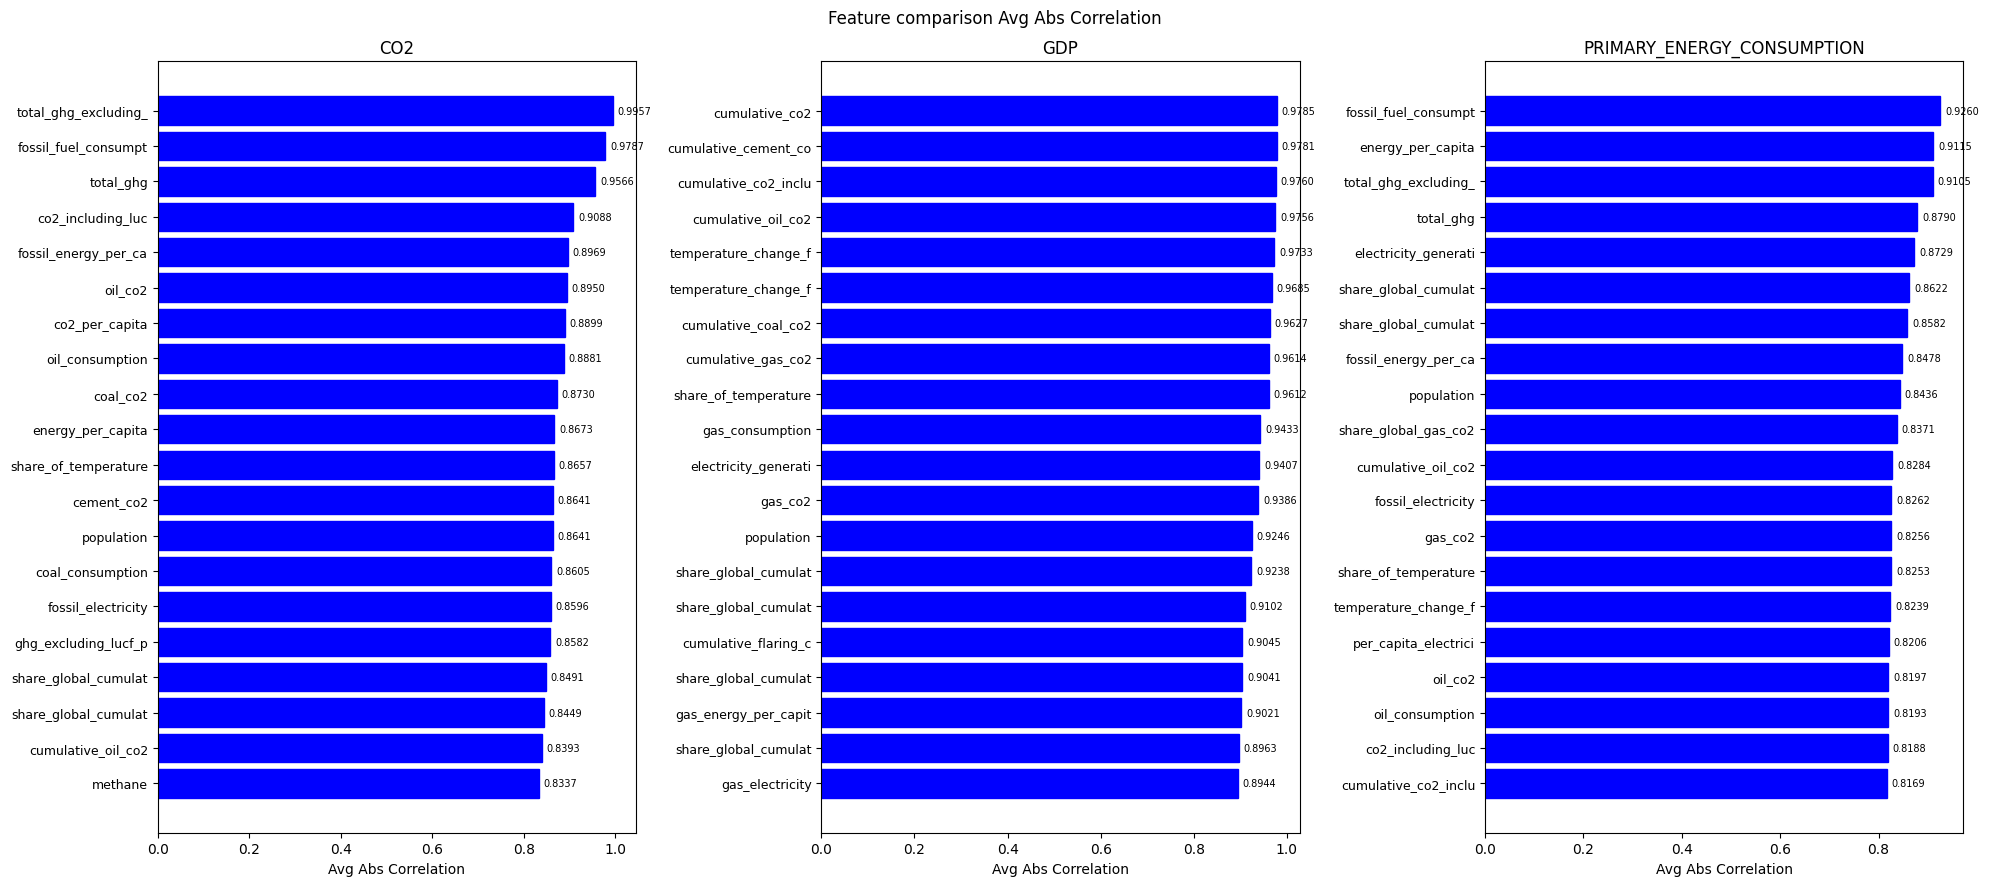

In [24]:
plot_comparison(feature_importance_scores, 'avg_abs_correlation')

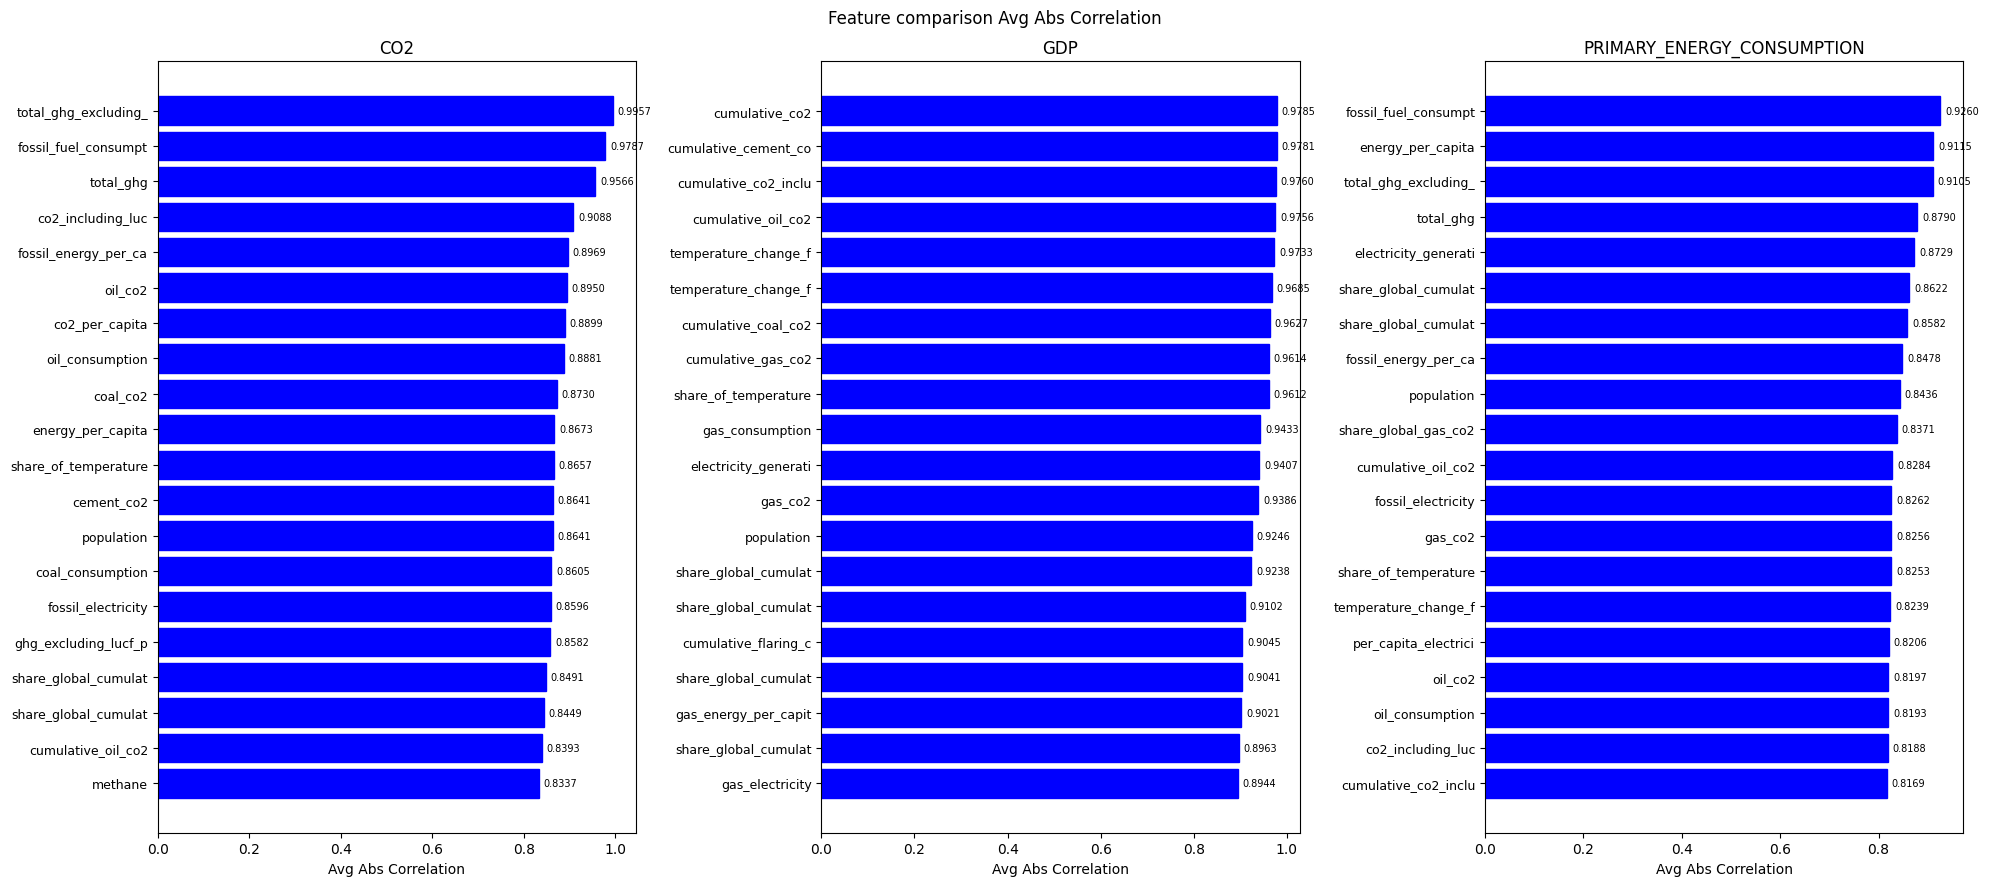

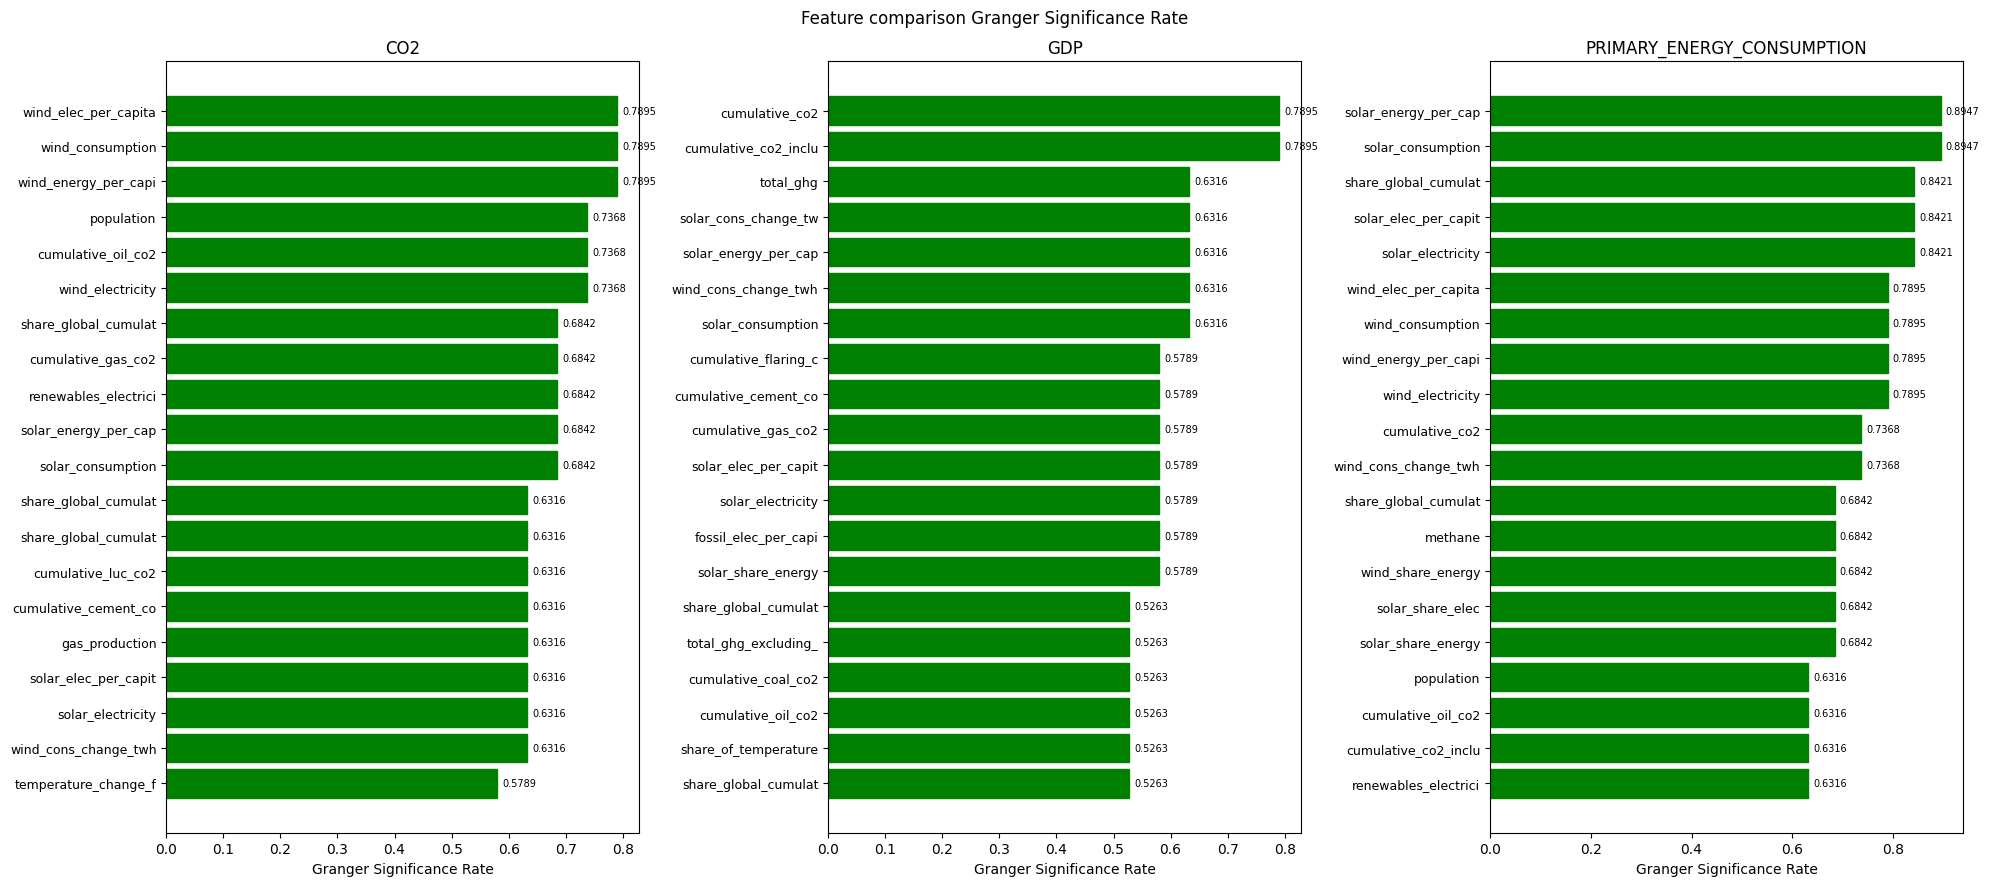

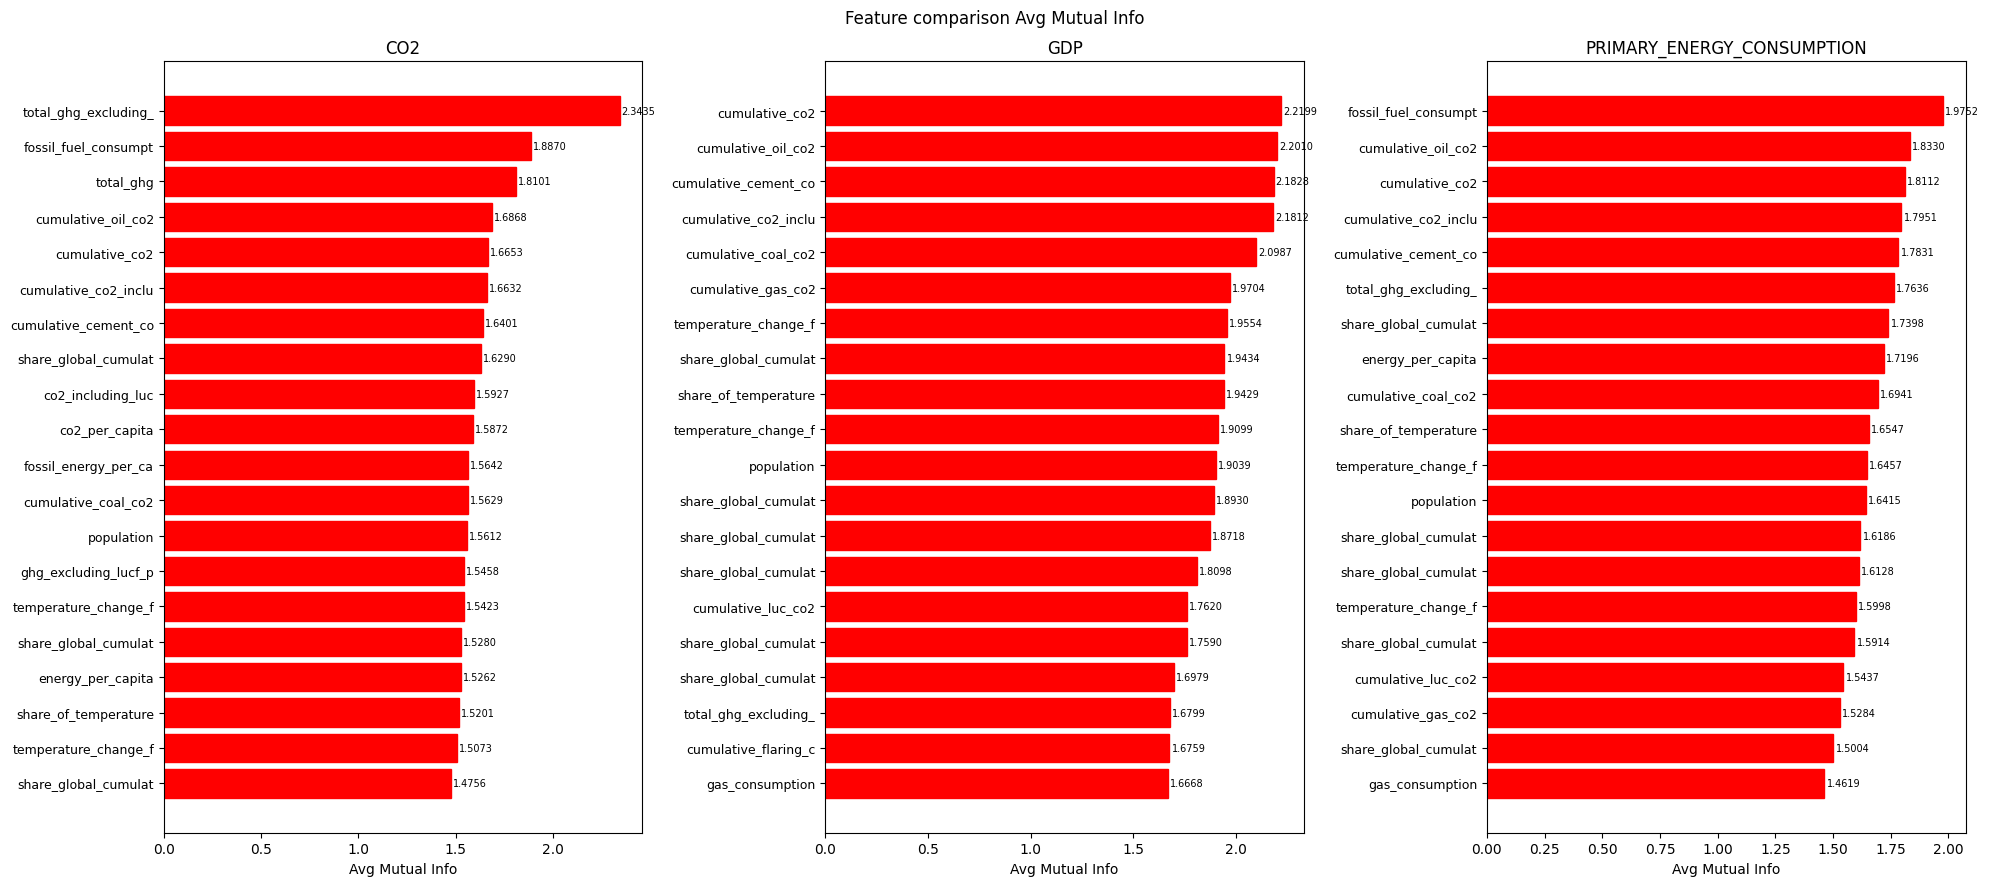

In [25]:
metrics = ['avg_abs_correlation', 'granger_significance_rate', 'avg_mutual_info']
for metric in metrics:
    plot_comparison(feature_importance_scores, metric)